## Exponential Smoothing
[Stats Model Exponential Smoothin](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

### Set Up Data

In [3]:
#parse datetime with weird timezone format
def parse_datetime_with_timezone(dt_str):
    datetime_str = dt_str[:-3] + dt_str[-2:]
    return pd.to_datetime(datetime_str, utc=True, format="%Y-%m-%d %H:%M:%S%z")

# TODO RE-Write without using "date_parser"
df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')

# Make sure this is the right timezone 
df.index = df.index.tz_convert('America/New_York')

#Set the frequency
#we need to do this before using in STL 
df= df.asfreq(freq='h')

/var/folders/n9/fmlq1lnj2f7d297hfrdwxdb80000gn/T/ipykernel_78081/1879699630.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("LMPSWide2023.csv", parse_dates=['Time'], date_parser=parse_datetime_with_timezone, index_col='Time')


In [4]:
df.drop(columns=["KCPLIATANUNIAT2","KCPLLACYGNEUNLAC2","SECI.KCPS.CIMARRON", "WR.LEC.4", "WR.JEC.2", "WR.JEC.3", "SECI.KCPS.CIMARRON"], inplace=True)

* create the model for one pricing node
* split the data into train and test sets

In [5]:
cimarron=df[["SECI_CIMARRON"]]

#Hold back last week as test set
cimarron_train = cimarron.iloc[:-168]
cimarron_test = cimarron.iloc[-168:]

### Simple Exponential Smoothing

Fit three models $\alpha = 0.2$,$\alpha=0.6$,and for the third $\alpha$ is by optimized

In [6]:
fit1 = SimpleExpSmoothing(cimarron_train, initialization_method = "heuristic").fit(smoothing_level=0.2, optimized=False)
fit2 = SimpleExpSmoothing(cimarron_train, initialization_method = "heuristic").fit(smoothing_level=0.6, optimized=False)
fit3 = SimpleExpSmoothing(cimarron_train, initialization_method = "estimated").fit()

fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

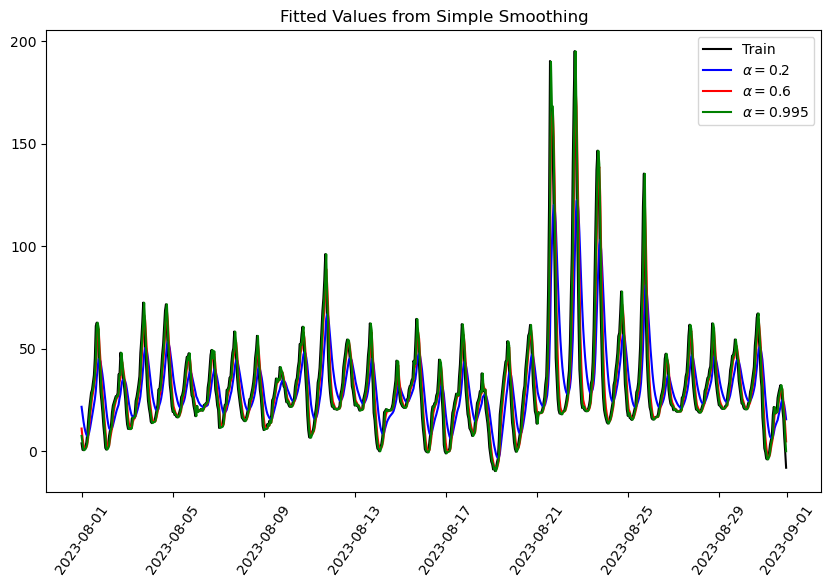

In [20]:
plt.figure(figsize=(10,6))
plt.plot(cimarron_train.loc["2023-08"], color = "black", label = "Train")
plt.plot(fit1.fittedvalues.loc["2023-08"], color="blue", label = r"$\alpha=0.2$")
plt.plot(fit2.fittedvalues.loc["2023-08"], color="red", label = r"$\alpha=0.6$")
plt.plot(fit3.fittedvalues.loc["2023-08"], color="green", label = r"$\alpha=%s$" % fit3.model.params["smoothing_level"])
plt.tick_params(axis='x', rotation=55)
plt.title("Fitted Values from Simple Smoothing")
plt.legend()

* optimized $\alpha$ is nearly 1, so the most recent observations have the biggest weight

### Holt's Method

* Our data for one year does not present a steady trend so we wouldn't expect Holts linear trend method to improve the model greatly  
* Fit two models again the first $\alpha = 0.95$ and $\beta=.2$, fit2 we use dampening parameter $\phi$ and let it be optimized while fixing alpha and beta as in the first model

In [15]:
Hfit1 = Holt(cimarron_train, initialization_method = 'estimated').fit(
    smoothing_level = .95, smoothing_trend = .2, optimized=False)
Hfit2 = Holt(cimarron_train, damped_trend=True, initialization_method = 'estimated').fit(
    smoothing_level = .95, smoothing_trend = .2)

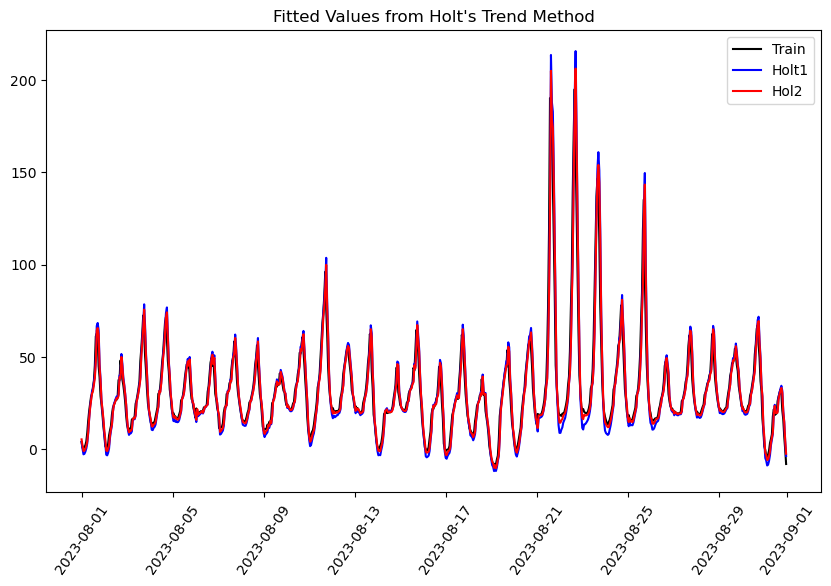

In [19]:
plt.figure(figsize=(10,6))
plt.plot(cimarron_train.loc["2023-08"], color = "black", label="Train")
plt.plot(Hfit1.fittedvalues.loc["2023-08"], color="blue", label="Holt1")
plt.plot(Hfit2.fittedvalues.loc["2023-08"], color="red", label= "Hol2")
plt.tick_params(axis='x', rotation=55)
plt.title("Fitted Values from Holt's Trend Method")
plt.legend()

### Methods with Seasonality
* Our data has strong daily cycles so we would hope to see improvement in our model with the inclusion of the seasonal component
* Our data has negative values so we will only consider Holt's additive method
* The frist model we will fit with a seasonal cycle of 1 day, the second will be fit with a cycle of 1 week

In [27]:
HWfit1 = ExponentialSmoothing(
    cimarron_train,
    seasonal_periods=24,
    trend="add",
    seasonal="add",
    use_boxcox=False,
    initialization_method="estimated",
).fit()

HWfit2 = ExponentialSmoothing(
    cimarron_train,
    seasonal_periods=168,
    trend="add",
    seasonal="add",
    use_boxcox=False,
    initialization_method="estimated",
).fit()

Text(0.5, 1.0, "Fitted Values From Holt-Winters' Method")

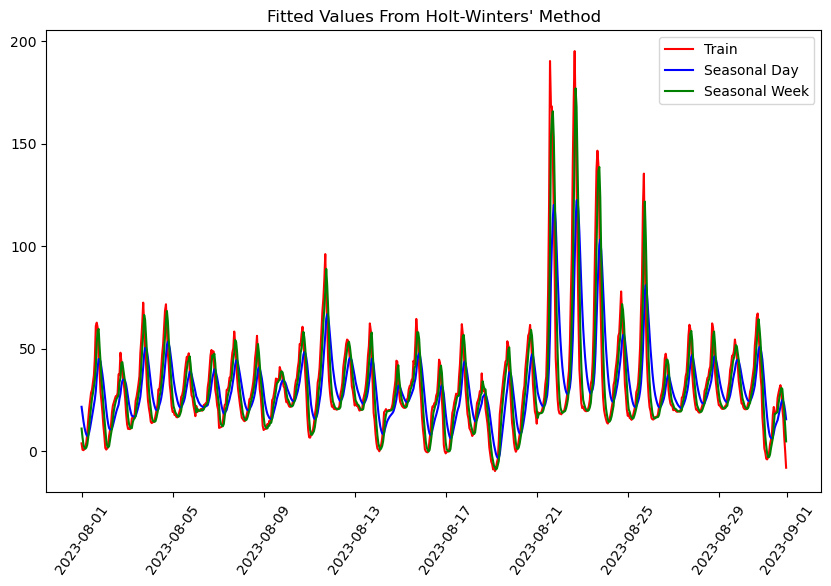

In [57]:
plt.figure(figsize=(10,6))
plt.plot(cimarron_train.loc["2023-08"], color = "red", label="Train")
plt.plot(fit1.fittedvalues.loc["2023-08"], color="blue", label="Seasonal Day")
plt.plot(fit2.fittedvalues.loc["2023-08"], color="green", label="Seasonal Week")
plt.tick_params(axis='x', rotation=55)
plt.legend()
plt.title("Fitted Values From Holt-Winters' Method")

* We can inspect each component of the model to get a better feel for how the season component is modeled

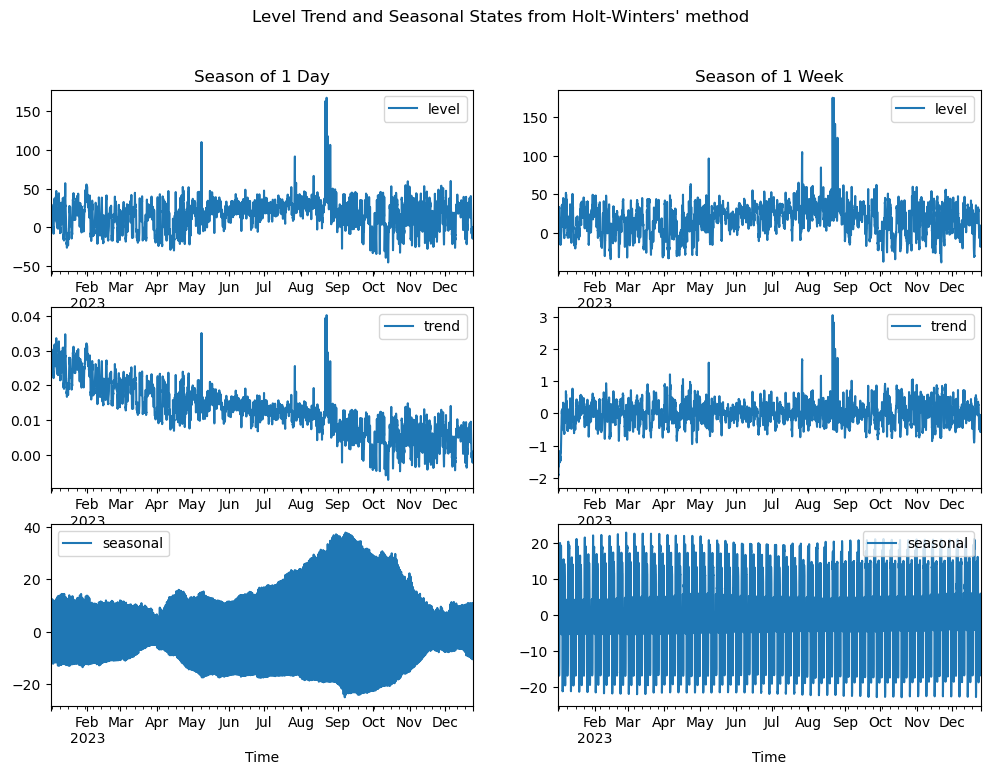

In [52]:
states1 = pd.DataFrame(
    np.c_[HWfit1.level, HWfit1.trend, HWfit1.season],
    columns=["level", "trend", "seasonal"],
    index=cimarron_train.index,
)
states2 = pd.DataFrame(
    np.c_[HWfit2.level, HWfit2.trend, HWfit2.season],
    columns=["level", "trend", "seasonal"],
    index=cimarron_train.index,
)

fig, [[ax1, ax4], [ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize=(12, 8))
states1[["level"]].plot(ax=ax1)
states1[["trend"]].plot(ax=ax2)
states1[["seasonal"]].plot(ax=ax3)
states2[["level"]].plot(ax=ax4)
states2[["trend"]].plot(ax=ax5)
states2[["seasonal"]].plot(ax=ax6)
fig.suptitle("Level Trend and Seasonal States from Holt-Winters' method")
ax1.set_title("Season of 1 Day")
ax4.set_title("Season of 1 Week")
plt.show()

### Innovations state space models for exponential smoothing
* turns the method for point forecast into stochastic model
* allows the use of prediction intervals, likihood, infomration criteria for model selection
* stochastic model with Additive error dist or multiplicative error dist
* models will produce the same point forecast but different confidence intervals
* multiplicative erros only work on postive data: we need to transform or use only the additive model

### Estimation and Model Selection
* Model selection criteria: AIC Corrected AIC and BIC
* Minimizing AIC (with normal errors) is (asymptotically) equivalent to minimizing one step time series cross validation MSE
* huge results as we do not need to setup cross validation to select the best model
* The model with the minimum value of the AIC is often the best model for forecasting. For large values of T, minimising the AIC is equivalent to minimising the CV value
* We fit each model and optimize the parameters base on MLE, we then select the best model using AIC, produce forecasts and CIs
* some models are unstable
* lets compare Holts Method and Holt-Winters’ seasonal method with season set to days and weeks

In [30]:
pd.options.display.float_format = '{:,.2f}'.format

In [31]:
results = pd.DataFrame(
    index=["SSE", "AIC", "AICC", "BIC"],
    columns=["H1", "H2", "HWDay", "HWWeek"],
)
results["H1"] = [Hfit1.sse, Hfit1.aic, Hfit1.aicc, Hfit1.bic]
results["H2"] = [Hfit2.sse, Hfit2.aic, Hfit2.aicc, Hfit2.bic]
results["HWDay"] = [HWfit1.sse, HWfit1.aic, HWfit1.aicc, HWfit1.bic]
results["HWWeek"] = [HWfit2.sse, HWfit2.aic, HWfit2.aicc, HWfit2.bic]
results

,H1,H2,HWDay,HWWeek
SSE,"247,396.38","214,378.04","198,742.90","198,168.92"
AIC,"28,878.50","27,649.69","27,045.02","27,308.17"
AICC,"28,878.51","27,649.70","27,045.24","27,315.41"
BIC,"28,906.73","27,684.98","27,242.66","28,522.25"


* The model with the lowest AICC is the Holts Winter Seasonal where the season is set to 1 day, we will use this for forecasting
* Overall the AICC values are very high which would indicate exponential smoothing isn't the best approach

### Forecasts and CI


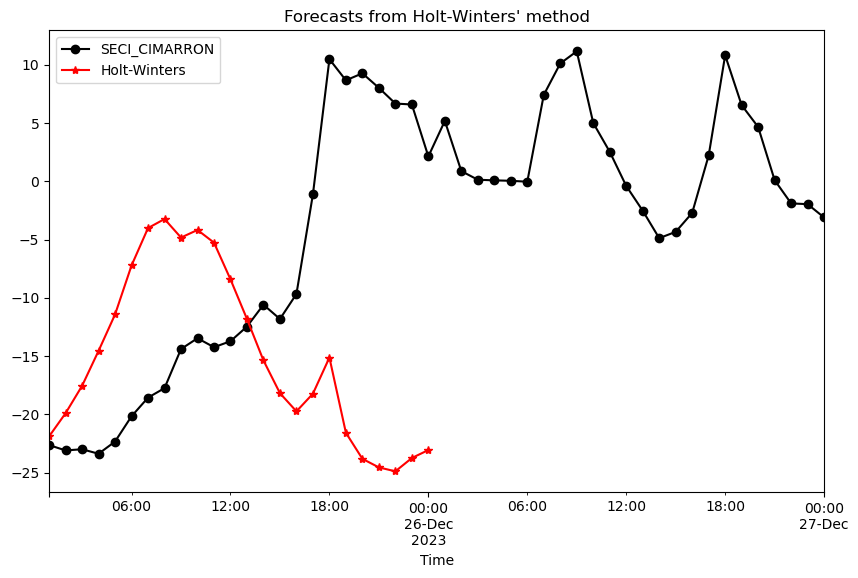

In [48]:
ax=cimarron_test[:48].plot(figsize=(10,6), marker="o", color="black", title="Forecasts from Holt-Winters' method")
HWfit1.forecast(24).rename("Holt-Winters").plot(ax=ax, marker = "*", color="red", legend=True)
plt.show()

* The model does not perform well on the test set
* Next we will run random simulations using the state space formulation to get prediction intervals
* use additive erros in the simulation as our data has negative values

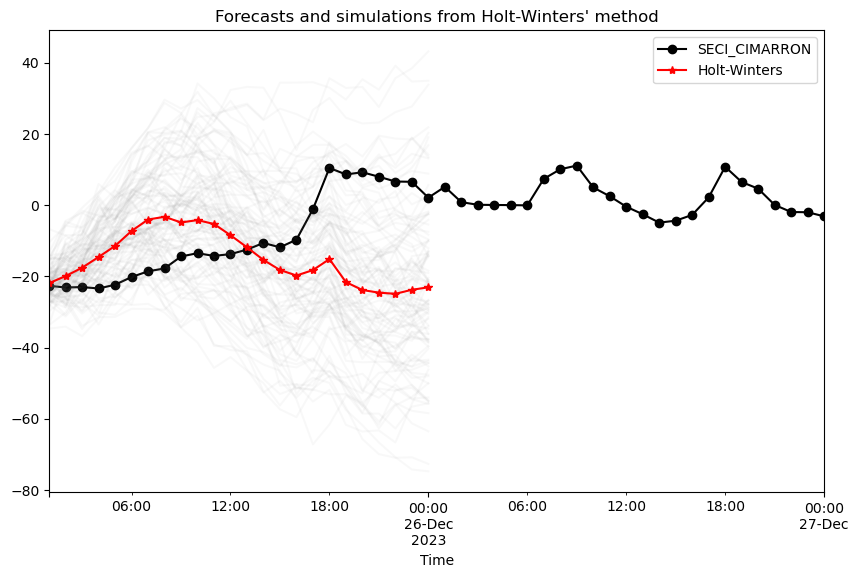

In [43]:
simulations = HWfit1.simulate(24, repetitions=100, error="add")

ax=cimarron_test[:48].plot(figsize=(10,6), marker="o", color="black", title="Forecasts and simulations from Holt-Winters' method",)
#it.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
HWfit1.forecast(24).rename("Holt-Winters").plot(ax=ax, marker = "*", color="red", legend=True)
plt.show()